In [1]:
%matplotlib inline
import nengo
import numpy as np
import matplotlib.pyplot as plt
import pytry

This notebook demonstrates the simple tool I use to run experiments to explore the effect of parameter settings.  The tool is called `pytry` and can be installed with `pip install pytry`

The main idea here is to take code that you've already written and do the minimal possible changes to it to allow you to start exploring the effects of parameter settings.  So let's start with an example code that I've already written: the simple Actor-Critic Reinforcement Learning model I wrote in https://github.com/neuromorphs/grill-eprop-lsnn/blob/master/rl/Implementing%20Actor-Critic%20RL%20in%20Nengo.ipynb

Here's that code below.  Note that I've made one change to it:  the Environment has a parameter `total_reward` which tracks the total amount of reward given to the agent.  That's to give us a simple metric to measure performance by.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

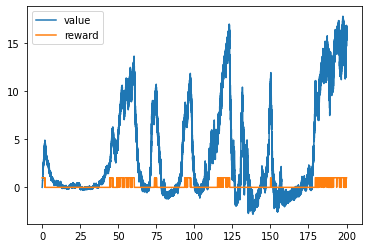

Total reward: 37959


In [4]:
class Environment:
    def __init__(self):
        self.theta = 0
        self.total_reward = 0
        
    def update(self, x):
        if x[0] > 0:
            self.theta += 0.01
        if x[1] > 0:
            self.theta -= 0.01
        reward = 1 if np.cos(self.theta)>0.95 else 0
        self.total_reward += reward
        return np.sin(self.theta), np.cos(self.theta), reward
    
tau_slow = 0.01
tau_fast = None
discount = 0.95

environment = Environment()
model = nengo.Network()
with model:
    
    # create the environment
    #   it has 3 outputs: the first 2 are the state, and the last is the reward
    env = nengo.Node(lambda t, x: environment.update(x), size_in=2, size_out=3)
    
    # set up some other Nodes that just grab the state and reward information,
    #  just for clarity
    state = nengo.Node(None, size_in=2)
    nengo.Connection(env[:2], state, synapse=None)
    reward = nengo.Node(None, size_in=1)
    nengo.Connection(env[2], reward, synapse=None)
    
    # create the neural network to encode the state.  The default is LIF neurons.
    ens = nengo.Ensemble(n_neurons=200, dimensions=2)
    nengo.Connection(state, ens, synapse=None)
    
    # this is the output value that we critic will learn
    value = nengo.Node(None, size_in=1)

    # record the value and the reward
    p_value = nengo.Probe(value)
    p_reward = nengo.Probe(reward)
    
    # compute the critic error
    value_error = nengo.Node(None, size_in=1)
    nengo.Connection(value, value_error, transform=-discount, synapse=tau_fast)
    nengo.Connection(value, value_error, synapse=tau_slow)
    nengo.Connection(reward, value_error, transform=-1, synapse=tau_slow)
    
    # make the connection to learn on
    c = nengo.Connection(ens.neurons, value, transform=np.zeros((1, ens.n_neurons)), 
                         learning_rule_type=nengo.PES(learning_rate=1e-4, pre_synapse=tau_slow))
    # connect the error signal to the learning rule
    nengo.Connection(value_error, c.learning_rule, synapse=None)

    ### HERE IS THE NEW STUFF FOR THE ACTOR
    
    # the raw output from the network
    raw_actions = nengo.Node(None, size_in=2, label='raw_actions')
    
    # compute the softmax
    def softmax(t, x):
        return np.exp(x)/np.sum(np.exp(x))
    actions = nengo.Node(softmax, size_in=2, label='actions')
    nengo.Connection(raw_actions, actions, synapse=None)

    # do the random sampling and output which action we're taking
    #  (here I just decided to represent choosing the action as +1 and not choosing as -1)
    def choice_func(t, x):
        c = np.random.choice(np.arange(2), p=x)
        result = [-1, -1]
        result[c] = 1
        return result
    choice = nengo.Node(choice_func, size_in=2, size_out=2, label='choice')
    nengo.Connection(actions, choice, synapse=None)
    
    # and now connect the choice to the environment
    nengo.Connection(choice, env, synapse=None)
    
    # and here is the computation of the error signal
    c_actor = nengo.Connection(ens.neurons, raw_actions, transform=np.zeros((2, ens.n_neurons)), 
                               learning_rule_type=nengo.PES(learning_rate=1e-4, pre_synapse=tau_slow))

    # implement the advantage actor-critic error rule
    #  the Node gets 5 inputs: the delta for the critic part, 2 values indicating which action was chosen
    #  (+1 for the chosen and -1 for the non-chosen ones), and the choice probabilities for the 2 actions
    def actor_error_func(t, x):
        delta = x[0]
        chosen = x[1:3]
        prob = x[3:5]
        # compute the error
        e = np.where(chosen>0, delta*(1-prob), -delta*prob)
        return e

    actor_error = nengo.Node(actor_error_func, size_in=5, label='actor_error')
    nengo.Connection(value_error, actor_error[0], synapse=None)
    nengo.Connection(choice, actor_error[1:3], synapse=None)
    nengo.Connection(actions, actor_error[3:5], synapse=None)
    nengo.Connection(actor_error, c_actor.learning_rule, transform=-1, synapse=tau_slow) 
    
    p_choice = nengo.Probe(choice)   # record the actual choices
    p_prob = nengo.Probe(actions)    # record the probabilities 
    
sim = nengo.Simulator(model)
sim.run(200)

plt.plot(sim.trange(), sim.data[p_value], label='value')
plt.plot(sim.trange(), sim.data[p_reward], label='reward')
plt.legend()
plt.show()

print('Total reward:', environment.total_reward)

So, that works and it seems like it's learning.  But I'd like to quantify that.  How well does it work without learning?  What happens if I adjust those other parameters?  To do that, I need to start playing with wrapping the code in big for loops and measuring results and saving them and whatnot.  It's not hard code to write, but it's annoying to do over and over again.  So here's what `pytry` does.

First, take all of your existing code and indent it twice.  Then we add a little bit at the top to define the parameters and a bit at the bottom to indicate what should be saved.  Here's what that looks like:

In [10]:
class RLTrial(pytry.Trial):
    def params(self):
        # here are the parameters you might want to vary.  For each one, you have some text indicating
        #  what the parameter is for, then a variable name and a default value.
        self.param('discount rate', discount=0.95)
        self.param('slow time constant for RL', tau_slow=0.01)
        self.param('learning rate', learning_rate=1e-4)
        self.param('run time', T=200.0)
        
    def evaluate(self, p):
        ############################################
        # this is the start of your original code, but indented twice to be inside this evaluate() function
        class Environment:
            def __init__(self):
                self.theta = 0
                self.total_reward = 0

            def update(self, x):
                if x[0] > 0:
                    self.theta += 0.01
                if x[1] > 0:
                    self.theta -= 0.01
                reward = 1 if np.cos(self.theta)>0.95 else 0
                self.total_reward += reward
                return np.sin(self.theta), np.cos(self.theta), reward

        # Here is how you access your parameters.  Just replace the parameter with "p.parameter_name"
        tau_slow = p.tau_slow
        tau_fast = None
        discount = p.discount

        environment = Environment()
        model = nengo.Network()
        with model:
            env = nengo.Node(lambda t, x: environment.update(x), size_in=2, size_out=3)

            state = nengo.Node(None, size_in=2)
            nengo.Connection(env[:2], state, synapse=None)
            reward = nengo.Node(None, size_in=1)
            nengo.Connection(env[2], reward, synapse=None)

            ens = nengo.Ensemble(n_neurons=200, dimensions=2)
            nengo.Connection(state, ens, synapse=None)

            value = nengo.Node(None, size_in=1)

            p_value = nengo.Probe(value)
            p_reward = nengo.Probe(reward)

            value_error = nengo.Node(None, size_in=1)
            nengo.Connection(value, value_error, transform=-discount, synapse=tau_fast)
            nengo.Connection(value, value_error, synapse=tau_slow)
            nengo.Connection(reward, value_error, transform=-1, synapse=tau_slow)

            c = nengo.Connection(ens.neurons, value, transform=np.zeros((1, ens.n_neurons)), 
                                 learning_rule_type=nengo.PES(learning_rate=p.learning_rate, pre_synapse=tau_slow))
            nengo.Connection(value_error, c.learning_rule, synapse=None)

            raw_actions = nengo.Node(None, size_in=2, label='raw_actions')

            def softmax(t, x):
                return np.exp(x)/np.sum(np.exp(x))
            actions = nengo.Node(softmax, size_in=2, label='actions')
            nengo.Connection(raw_actions, actions, synapse=None)

            def choice_func(t, x):
                c = np.random.choice(np.arange(2), p=x)
                result = [-1, -1]
                result[c] = 1
                return result
            choice = nengo.Node(choice_func, size_in=2, size_out=2, label='choice')
            nengo.Connection(actions, choice, synapse=None)

            nengo.Connection(choice, env, synapse=None)

            c_actor = nengo.Connection(ens.neurons, raw_actions, transform=np.zeros((2, ens.n_neurons)), 
                                       learning_rule_type=nengo.PES(learning_rate=p.learning_rate, pre_synapse=tau_slow))

            def actor_error_func(t, x):
                delta = x[0]
                chosen = x[1:3]
                prob = x[3:5]
                e = np.where(chosen>0, delta*(1-prob), -delta*prob)
                return e

            actor_error = nengo.Node(actor_error_func, size_in=5, label='actor_error')
            nengo.Connection(value_error, actor_error[0], synapse=None)
            nengo.Connection(choice, actor_error[1:3], synapse=None)
            nengo.Connection(actions, actor_error[3:5], synapse=None)
            nengo.Connection(actor_error, c_actor.learning_rule, transform=-1, synapse=tau_slow) 

            p_choice = nengo.Probe(choice)
            p_prob = nengo.Probe(actions)  

        sim = nengo.Simulator(model)
        sim.run(p.T)
        
        #################################################
        # Now we indicate what data should be saved.  Anything in this returned dictionary will be kept.
        return dict(
            total_reward=environment.total_reward,
            value=sim.data[p_value],
            reward=sim.data[p_reward]
        )

Given this code, we can now run it and adjust the parameter settings.

In [13]:
r = RLTrial().run(T=10, learning_rate=0)

running RLTrial#20200826-001140-284ca52c


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 1
discount = 0.95
tau_slow = 0.01
learning_rate = 0
T = 10
reward = array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])
total_reward = 4466
value = array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])


So, this has now encapsulated our experiment in a pretty simple way.

Pytry also adds a few parameters automatically.  In particular, it adds a `seed` parameter (which sets the Python and numpy random number seeds), and also parameters for where and how to store the data.  Each simulation run will be saved in a file with a name indicating what class was run and the timestamp.  So, we can now do a quick experiment seeing what happens with learning on or off.  We'll save the data in a directory `experiment1`.  Note that we're switching the data format to `.npz` so that it'll be good at saving the giant numpy arrays of data (if you don't have big arrays of data, it's fine to stick with the default `txt` format).

In [54]:
for seed in range(0,4):
    for learning_rate in [0, 1e-4]:
        RLTrial().run(T=500, learning_rate=learning_rate, seed=seed,
                      data_dir='experiment1', data_format='npz', verbose=False)

2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Now that the simulations have been run, we can look at the data.  Pytry lets you read in the data from a directory, and it returns it as a list of dictionaries.  This is exactly the format used by `pandas` so we can create a `pandas.DataFrame`.

In [70]:
import pandas
df = pandas.DataFrame(pytry.read('experiment1'))
df

,seed,discount,tau_slow,learning_rate,T,total_reward,value,reward
0,0,0.95,0.01,0.0000,500,54489,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
1,0,0.95,0.01,0.0001,500,10847,"[[0.0], [0.0], [0.0], [0.0], [2.62953358948162...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
2,1,0.95,0.01,0.0000,500,62307,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
3,1,0.95,0.01,0.0001,500,27862,"[[0.0], [0.0], [0.0], [0.0], [1.21363088745305...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
4,2,0.95,0.01,0.0000,500,76300,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
5,2,0.95,0.01,0.0001,500,24670,"[[0.0], [0.0], [0.0], [0.0], [4.04543629151019...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
6,3,0.95,0.01,0.0000,500,80828,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
7,3,0.95,0.01,0.0001,500,27123,"[[0.0], [0.0], [0.0], [0.0], [2.42726177490611...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


And now let's plot the data using `seaborn`.  This automatically does a bootstrap confidence interval for us.

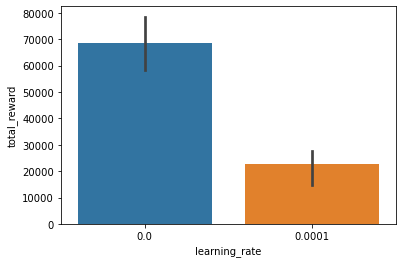

In [71]:
import seaborn
seaborn.barplot('learning_rate', 'total_reward', data=df)

Hmm, that's odd.  It looks like learning is making things worse!  Let's look closer at the data and see what's happening.

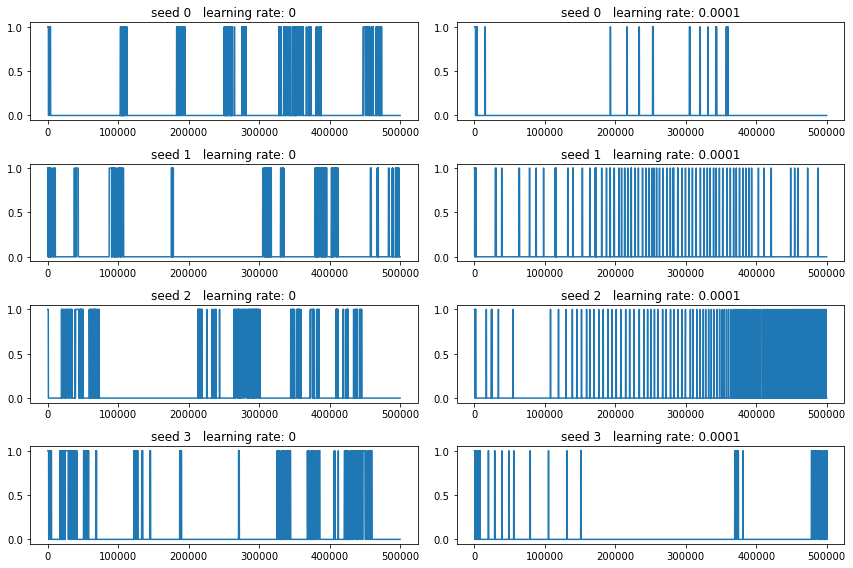

In [77]:
plt.figure(figsize=(12,8))
data = list(pytry.read('experiment1'))
N = len(data)
for i, d in enumerate(data):
    plt.subplot(N//2, 2, i+1)
    plt.plot(d['reward'])
    plt.title('seed %d   learning rate: %g' % (d['seed'], d['learning_rate']))
plt.tight_layout()

Ah.  The learning system is working (usually), but the non-learning one is also randomly getting rewards too.  So it looks like the learning version is better later in the simulation run.  So instead of looking at the total reward, let's just look at the reward in the last 20000 time steps.   (Note: we'd probably also take this as evidence that we should run the model for longer (maybe `T=1000`) to get a better measure).  

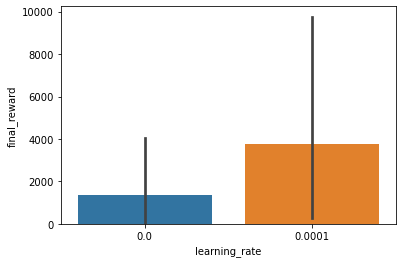

In [75]:
data = []
for d in pytry.read('experiment1'):
    r = d['reward']
    d['final_reward'] = np.sum(r[-20000:])  # compute total reward in the last 20000 timesteps
    data.append(d)
df = pandas.DataFrame(data)
seaborn.barplot('learning_rate', 'final_reward', data=df)

That looks like an improvement, but the confidence intervals are definitely indicating that more simulations are needed for that to be statistically significant.